# Artificial Intelligence Project

## Group 1:
### - Rajoelisoa Enorian
### - Hirli Baptiste
### - Bhattacharjee Ankit
### - Caumartin Evan

# Data Preprocessing

### 1. Load the data
### 2. Merge the data
### 3. Calculate the average working time
### 4. Remove the outliers
### 5. Drop the unnecessary columns
### 6. Encode the categorical data
### 7. Impute the missing values
### 8. Scale the data
### 9. Save the data

In [569]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [570]:
full_employee_data: pd.DataFrame = pd.DataFrame()

is_ethic = False

# Load the data

### Load the data from the datasets folder

We read multiple CSV files into pandas DataFrames. The general_data, employee_survey_data, and manager_survey_data DataFrames contain general, employee survey, and manager survey data, respectively. The in_time and out_time DataFrames contain timestamp data for employee check-in and check-out times, which are converted to datetime format.

In [571]:
general_data = pd.read_csv('datasets/general_data.csv')
employee_survey_data = pd.read_csv('datasets/employee_survey_data.csv')
manager_survey_data = pd.read_csv('datasets/manager_survey_data.csv')
in_time: pd.DataFrame = pd.read_csv('datasets/in_time.csv', parse_dates=True)
out_time = pd.read_csv('datasets/out_time.csv', parse_dates=True)

# Merge the data

We are merging general data, employee survey data, and manager survey data into a single DataFrame.

In [572]:
full_employee_data = general_data.merge(employee_survey_data, on='EmployeeID')
full_employee_data = full_employee_data.merge(manager_survey_data, on='EmployeeID')

# Calculate the average working time

We analyzed employee working patterns by calculating key metrics such as average arrival time, departure time, and working hours. Starting with arrival (`in_time`) and departure (`out_time`) datasets, we determined the total time spent at work each day by subtracting arrival times from departure times and converting the results into hours.
(Here, we assumed that the arrival and departure times were on the same day to simplify the analysis. If the data spanned multiple days, additional processing would be required to account for overnight shifts.)
We then calculated the **AverageArrivalTime** (mean of arrival times), **AverageDepartureTime** (latest departure time), and **AverageWorkingTime** (average daily working hours) for each employee. These insights were combined into a new dataset and merged with the general employee data to provide a comprehensive view, including details like name and department alongside their working time metrics.
For instance, an employee arriving at 9:15 AM and leaving at 6:30 PM consistently would have an average working time of 9 hours. This analysis helps in understanding employee work habits, identifying trends, and improving operational efficiency.

In [573]:
# Fill missing values
in_time = in_time.fillna('1970-01-01 00:00:00')
out_time = out_time.fillna('1970-01-01 00:00:00')

# Convert all times to datetime
in_time.iloc[:, 1:] = in_time.iloc[:, 1:].apply(pd.to_datetime).apply(lambda x: x.dt.hour * 3600 + x.dt.minute * 60 + x.dt.second)
out_time.iloc[:, 1:] = out_time.iloc[:, 1:].apply(pd.to_datetime).apply(lambda x: x.dt.hour * 3600 + x.dt.minute * 60 + x.dt.second)

# Replace 0 with row medians using mask or where to avoid the FutureWarning
in_time.iloc[:, 1:] = in_time.iloc[:, 1:].apply(lambda row: row.mask(row == 0, row.median()), axis=1)
out_time.iloc[:, 1:] = out_time.iloc[:, 1:].apply(lambda row: row.mask(row == 0, row.median()), axis=1)

# Calculate working time for each day in hours
working_time = (out_time.iloc[:, 1:] - in_time.iloc[:, 1:])

# Average arrival time
average_arrival_time = in_time.iloc[:, 1:].mean(axis=1)

# Average departure time
average_departure_time = out_time.iloc[:, 1:].max(axis=1)

# Calculate average working time
average_working_time = working_time.mean(axis=1) / 3600

# Convert average times directly to total seconds
result = pd.DataFrame({
    'EmployeeID': in_time.iloc[:, 0],  # Use the first column directly
    'AverageArrivalTime': average_arrival_time.round(0).astype(int),
    'AverageDepartureTime': average_departure_time.round(0).astype(int),
    'AverageWorkingTime': average_working_time.round(2)
})

result.to_csv('working_time_data.csv', index=False)

# Merge with other employee data
full_employee_data = full_employee_data.merge(result, on='EmployeeID')

# Remove the outliers

We removed the outliers from the dataset using the Interquartile Range (IQR) method. Outliers are data points that significantly differ from other observations in the dataset. They can skew the results of statistical analyses and machine learning models.
The IQR method identifies outliers by calculating the range between the first and third quartiles of the data and flagging values that fall below the lower bound (Q1 - 1.5 * IQR) or above the upper bound (Q3 + 1.5 * IQR). Outliers are then replaced with the lower or upper bound values to ensure they do not impact the analysis.

In [574]:
def find_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers

def cap_outliers_in_dataframe(df):
    df = df.copy()

    for column in df.columns:
        if np.issubdtype(df[column].dtype, np.number):  # Check if the column contains numeric data
            outliers = find_outliers_iqr(df[column])

            # Cap the outliers by replacing them with lower/upper bounds
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            df[column] = np.where(outliers, np.clip(df[column], lower_bound, upper_bound), df[column])

    return df

In [575]:
full_employee_data = cap_outliers_in_dataframe(full_employee_data)

## Display the first 5 rows of the data

We displayed the first five rows of the dataset to understand its structure and contents. This step provides an overview of the data, including the column names, data types, and values. It helps in identifying any potential issues, such as missing values, outliers, or incorrect data types.

In [576]:
full_employee_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AverageArrivalTime,AverageDepartureTime,AverageWorkingTime
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,0.0,0.0,3.0,4.0,2.0,3,3,35979.0,65646.0,7.376424
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,1.0,4.0,3.0,2.0,4.0,2,3,35943.0,67793.0,7.717551
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,0.0,3.0,2.0,2.0,1.0,3,3,36084.0,65271.0,7.010861
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,7.0,5.0,4.0,4.0,3.0,2,3,35920.0,65416.0,7.194391
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,0.0,4.0,4.0,1.0,3.0,3,3,35986.0,69721.0,8.005762


## Display the shape of the data

We displayed the shape of the dataset to determine the number of rows and columns it contains. This information is essential for understanding the size and structure of the data, which can impact the analysis and modeling process.

In [577]:
full_employee_data.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AverageArrivalTime,AverageDepartureTime
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4391.000000,4410.000000,4410.0,...,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.0,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,63620.857143,2.677067,15.209524,8.0,...,6.617687,1.922789,4.107483,2.723603,2.728246,2.761436,2.729932,3.0,35986.110544,67844.446145
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,43528.133258,2.455392,3.659108,0.0,...,4.988656,2.477660,3.516689,1.092756,1.101253,0.706245,0.711400,0.0,64.971285,4834.530025
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.0,35811.500000,60571.000000
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,...,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.0,35942.000000,64110.000000
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,...,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0,35987.000000,66870.500000
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,...,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.0,36029.000000,70153.000000
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,165835.000000,8.500000,25.000000,8.0,...,18.000000,7.500000,14.500000,4.000000,4.000000,4.000000,4.000000,3.0,36159.500000,79217.500000


## Display the columns of the data

We displayed the column names of the dataset to identify the variables or features available for analysis. Understanding the columns helps in selecting relevant data for specific tasks, such as predictive modeling, clustering, or classification.

In [578]:
full_employee_data.isna().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
AverageArrivalTime          0
AverageDepartureTime        0
AverageWorkingTime          0
dtype: int64

# Drop the unnecessary columns

We dropped the unnecessary columns from the dataset to focus on the relevant features for analysis. Removing redundant or irrelevant columns helps in reducing the dimensionality of the data and improving the performance of machine learning models.

The columns `EmployeeCount`, `Over18`, and `StandardHours` were dropped as they contained constant values for all employees and did not provide any useful information for analysis.

The `EmployeeID` column was also removed as it served as an identifier and was not required for further analysis.

In [579]:
# EmployeeCount : All values are 1
# Over18 : All values are 'Y'
# StandardHours : All values are 8
columns_to_drop = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeID']

# Drop additional columns if is_ethic is True
if is_ethic:
    columns_to_drop += ['Age', 'Education', 'MaritalStatus', 'Gender', 'EducationField']

full_employee_data = full_employee_data.drop(columns_to_drop, axis=1)

# Encode the categorical data

In this step, **we encoded categorical variables** in the employee dataset to prepare the data for machine learning models, which typically require numerical inputs. We targeted specific categorical columns: `Department`, `BusinessTravel`, `JobRole`, `MaritalStatus`, `Gender`, and `EducationField`.
For each of these columns, we used **one-hot encoding**, a technique that converts each unique category into separate binary columns. For example, if the `Department` column contains values like "Sales," "HR," and "R&D," one-hot encoding will create three new columns: `Department_Sales`, `Department_HR`, and `Department_R&D`. Each row will have a value of `1` in the relevant column and `0` in the others. This ensures that the categorical data is represented numerically without introducing any unintended ordinal relationships.

To maintain flexibility, we first checked if each column in the list still existed in the dataset before applying the encoding. This avoids errors if columns were previously removed or altered. After encoding, the original categorical columns were dropped from the dataset to avoid redundancy. In addition to encoding, we transformed the **`Attrition`** column, which indicates whether an employee has left the company, into binary values.
Specifically, we mapped `'Yes'` to `1` and `'No'` to `0`, making it suitable for classification models. This binary encoding enables the model to treat attrition as a target variable for predictive analysis. By the end of this process, all relevant categorical features and the target variable were represented numerically, ensuring the dataset was ready for further data processing or model training.

In [580]:
#Encoding
cat_data = ['Department', 'BusinessTravel', 'JobRole', 'MaritalStatus', 'Gender', 'EducationField']

# Only encode columns that are still present in the dataframe
for i in cat_data:
    if i in full_employee_data.columns:
        vals = pd.get_dummies(full_employee_data[i], sparse=True)
        full_employee_data = pd.concat([full_employee_data, vals], axis=1)
        full_employee_data = full_employee_data.drop(i, axis=1)

# Map Attrition column to binary values
full_employee_data['Attrition'] = full_employee_data['Attrition'].map({'Yes': 1, 'No': 0})

# Impute the missing values

In this step, we **imputed missing values** in the dataset to ensure that the data was complete and ready for analysis. Missing values can occur due to various reasons, such as data entry errors, system failures, or incomplete records. Imputation is the process of filling in missing values with estimated or calculated values based on the available data.
We used the **SimpleImputer** class from scikit-learn to impute missing values in the dataset. We chose the **median strategy** to replace missing values with the median of each column. The median is a robust measure of central tendency that is less sensitive to outliers than the mean. By imputing missing values with the median, we aimed to maintain the integrity of the data and avoid introducing bias or distortion.
After imputing missing values, we checked the dataset for any remaining null values to confirm that the imputation process was successful. This ensured that the data was clean, complete, and ready for further analysis or modeling.

In [581]:
#Imputation
imputer = SimpleImputer(strategy='median')

for cat_name in full_employee_data.columns:
    full_employee_data[cat_name] = imputer.fit_transform(full_employee_data[[cat_name]])

print(full_employee_data.isnull().sum())

Attrition                    0
DistanceFromHome             0
JobLevel                     0
MonthlyIncome                0
NumCompaniesWorked           0
PercentSalaryHike            0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
YearsAtCompany               0
YearsSinceLastPromotion      0
YearsWithCurrManager         0
EnvironmentSatisfaction      0
JobSatisfaction              0
WorkLifeBalance              0
JobInvolvement               0
PerformanceRating            0
AverageArrivalTime           0
AverageDepartureTime         0
AverageWorkingTime           0
Human Resources              0
Research & Development       0
Sales                        0
Non-Travel                   0
Travel_Frequently            0
Travel_Rarely                0
Healthcare Representative    0
Human Resources              0
Laboratory Technician        0
Manager                      0
Manufacturing Director       0
Research Director            0
Research

# Scale the data

In this step, we **scaled the data** to ensure that all features were on a similar scale, which is essential for many machine learning algorithms. Scaling the data helps in improving the performance and convergence of models by ensuring that no single feature dominates the others.
We used the **MinMaxScaler** class from scikit-learn to scale the data to a specific range. Min-max scaling transforms the data to a specified range (default is 0 to 1) by subtracting the minimum value and dividing by the range. This normalization technique preserves the relationships between the data points while ensuring that all features are within the same scale.
After scaling the data, we checked the summary statistics of the dataset to confirm that all features were scaled appropriately. This step ensured that the data was ready for further analysis, modeling, or visualization.

In [582]:
# Scaling
scaler = MinMaxScaler()

for cat_name in full_employee_data.columns:
    full_employee_data[cat_name] = scaler.fit_transform(full_employee_data[[cat_name]])
    
print(full_employee_data.head())

   Attrition  DistanceFromHome  JobLevel  MonthlyIncome  NumCompaniesWorked  \
0        0.0          0.178571      0.00       0.777360            0.117647   
1        1.0          0.321429      0.00       0.204180            0.000000   
2        0.0          0.571429      0.75       1.000000            0.117647   
3        0.0          0.035714      0.50       0.469485            0.352941   
4        0.0          0.321429      0.00       0.085589            0.470588   

   PercentSalaryHike  StockOptionLevel  TotalWorkingYears  \
0           0.000000               0.0           0.035088   
1           0.857143               0.4           0.210526   
2           0.285714               1.0           0.175439   
3           0.000000               1.0           0.456140   
4           0.071429               0.8           0.315789   

   TrainingTimesLastYear  YearsAtCompany  ...  Travel_Rarely  \
0                  1.000        0.055556  ...            1.0   
1                  0.625      

   Attrition  DistanceFromHome  JobLevel  MonthlyIncome  NumCompaniesWorked  \
0        0.0          0.178571      0.00       0.777360            0.117647   
1        1.0          0.321429      0.00       0.204180            0.000000   
2        0.0          0.571429      0.75       1.000000            0.117647   
3        0.0          0.035714      0.50       0.469485            0.352941   
4        0.0          0.321429      0.00       0.085589            0.470588   

   PercentSalaryHike  StockOptionLevel  TotalWorkingYears  \
0           0.000000               0.0           0.035088   
1           0.857143               0.4           0.210526   
2           0.285714               1.0           0.175439   
3           0.000000               1.0           0.456140   
4           0.071429               0.8           0.315789   

   TrainingTimesLastYear  YearsAtCompany  ...  Travel_Rarely  \
0                  1.000        0.055556  ...            1.0   
1                  0.625      

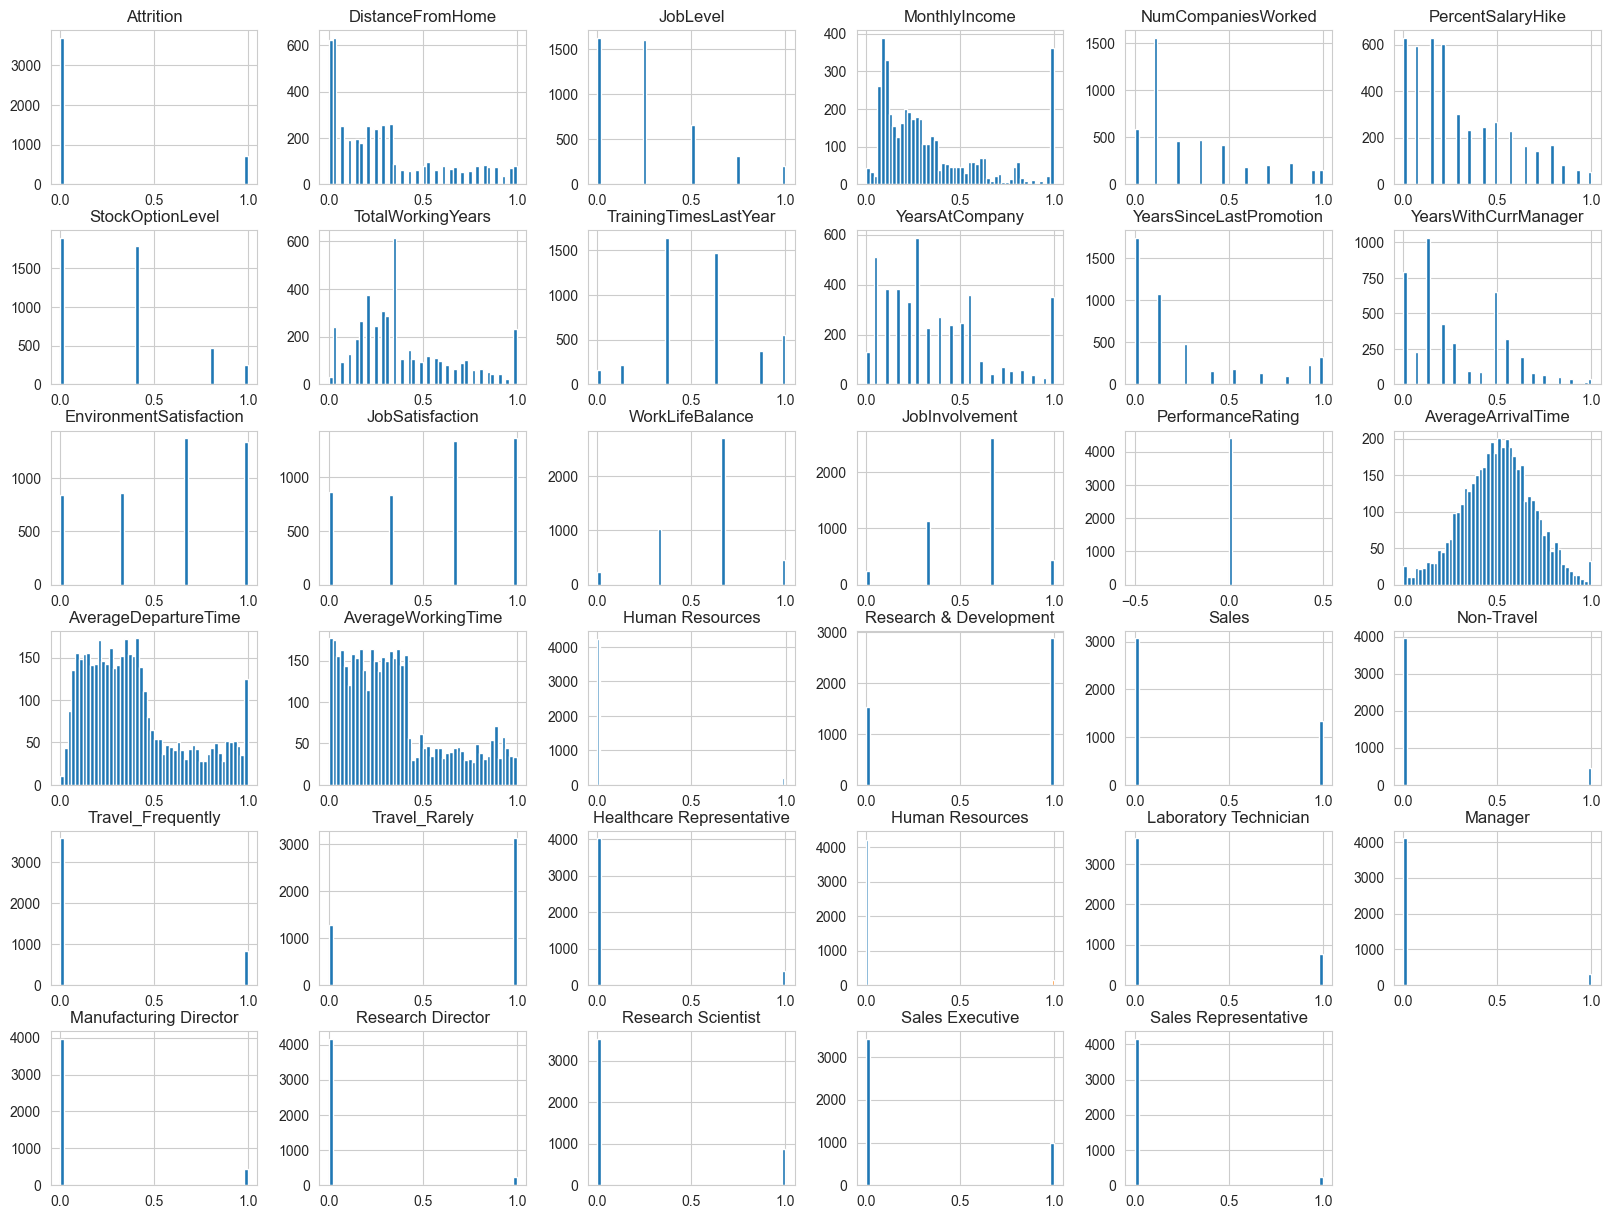

In [583]:
# Display the first 5 rows of the data
print(full_employee_data.head())

# Display the shape of the data
print(full_employee_data.shape)

# Display the columns of the data
print(full_employee_data.columns)

# Display the summary statistics of the data
print(full_employee_data.describe(include='all'))

# Display the missing values in the data
print(full_employee_data.isnull().sum())

# Display the unique values in the data
full_employee_data.hist(bins=50, figsize=(20, 15))
plt.show()

                         TotalWorkingYears  YearsAtCompany  \
TotalWorkingYears                      NaN        0.595742   
YearsAtCompany                    0.595742             NaN   
YearsSinceLastPromotion                NaN        0.589700   
YearsWithCurrManager                   NaN        0.833621   
AverageDepartureTime                   NaN             NaN   
AverageWorkingTime                     NaN             NaN   
Research & Development                 NaN             NaN   
Sales                                  NaN             NaN   
Non-Travel                             NaN             NaN   
Travel_Frequently                      NaN             NaN   
Travel_Rarely                          NaN             NaN   

                         YearsSinceLastPromotion  YearsWithCurrManager  \
TotalWorkingYears                            NaN                   NaN   
YearsAtCompany                          0.589700              0.833621   
YearsSinceLastPromotion          

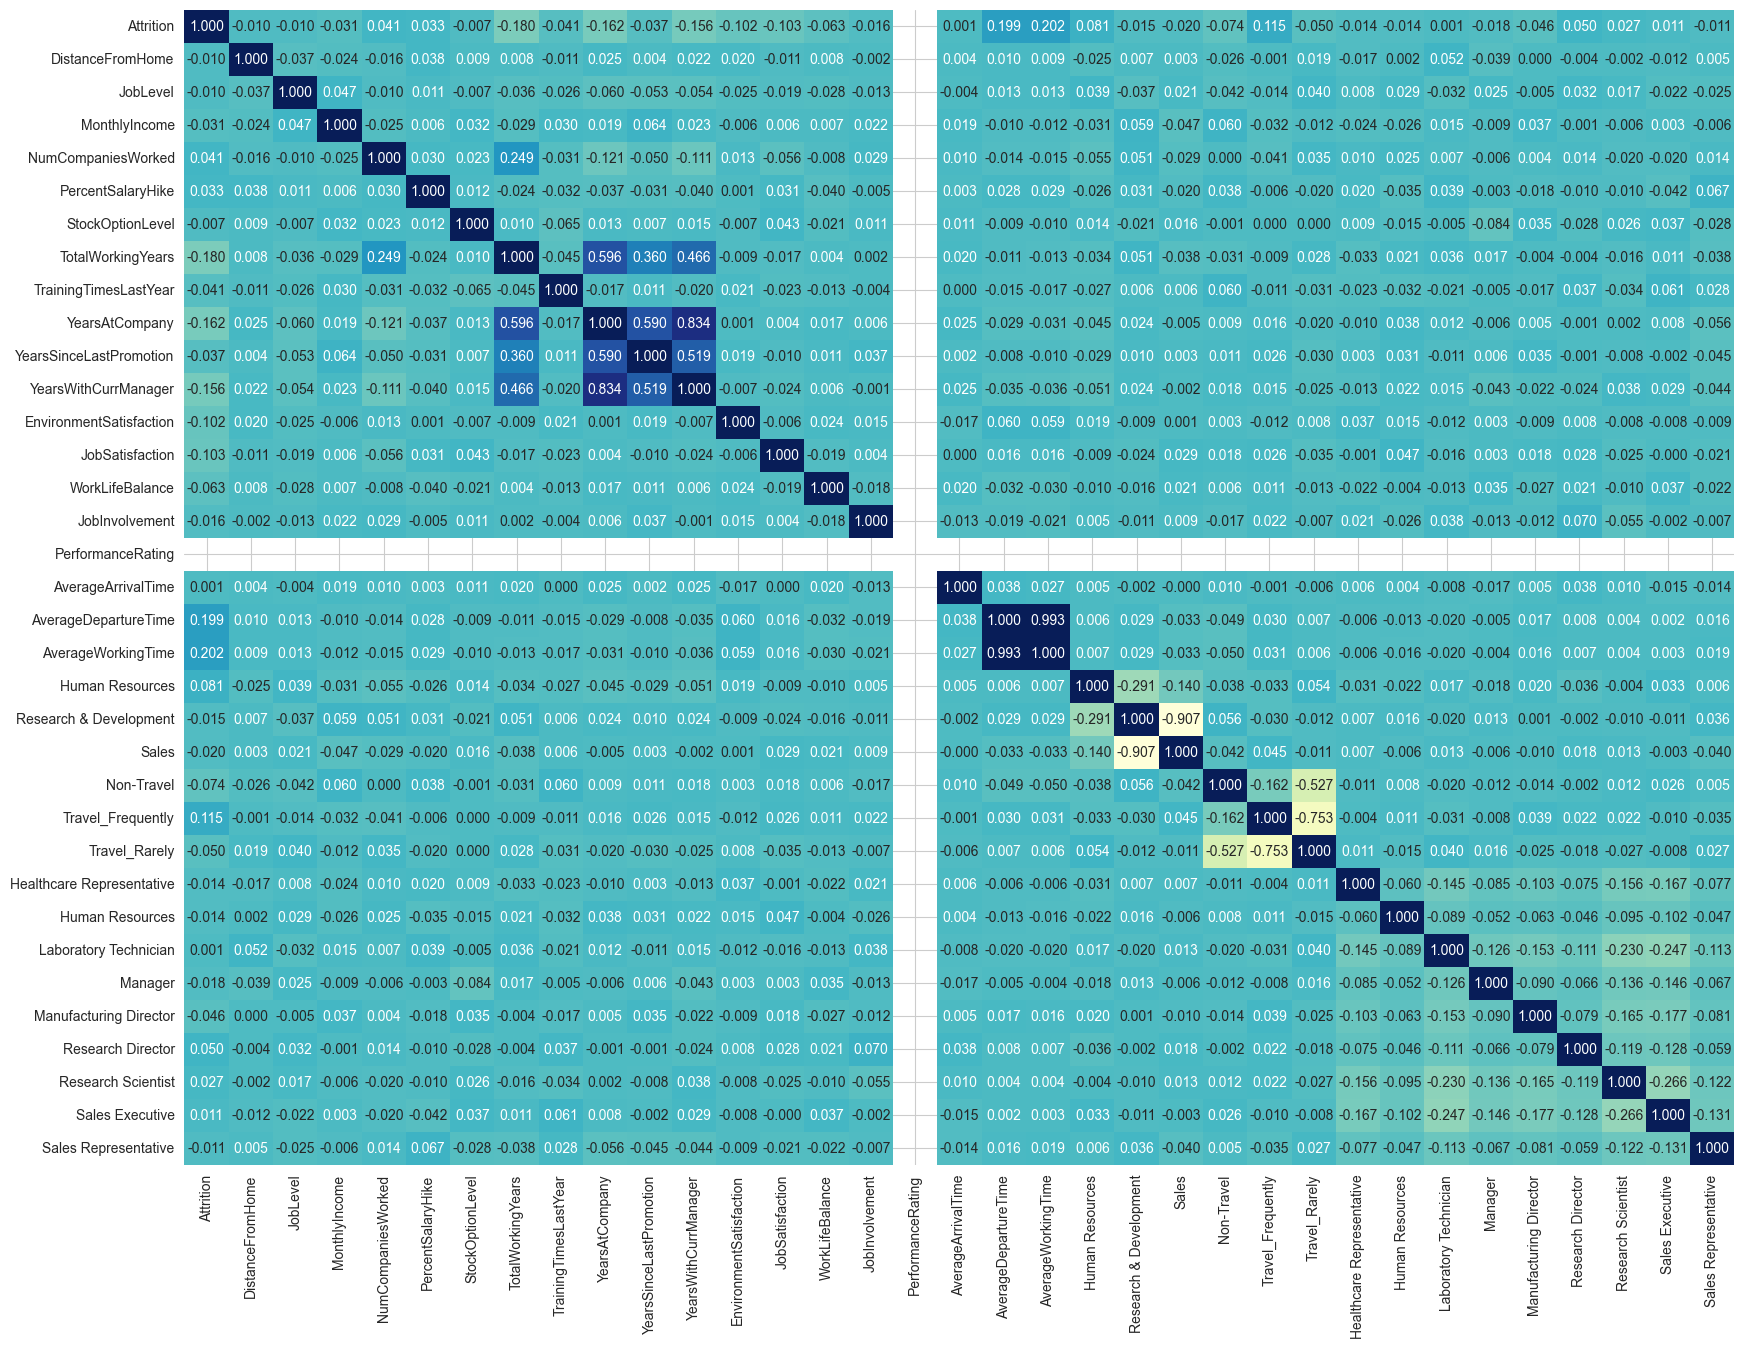

In [584]:
# Display the correlation matrix of the data
corr_matrix = full_employee_data.corr()

# Print the correlation of each data which is greater than 0.5 absolute
high_corr = corr_matrix[(np.abs(corr_matrix) > 0.5) & (corr_matrix != 1.0)]
print(high_corr.dropna(how='all', axis=0).dropna(how='all', axis=1))

# Create a heatmap of the correlation matrix
plt.figure(figsize=(20, 15), edgecolor='white')
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='YlGnBu', cbar=False)
plt.show()

In [585]:
# Remove the columns with high correlation


In [586]:
full_employee_data.to_csv('full_employee_data_cleaned.csv', index=False)